In [1]:
# ML_in_Finance-2D-CNNs
# Author: Matthew Dixon
# Version: 1.0 (28.4.2020)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X running Python 3.6.9 with the following packages:
# tensorflow=2.0.0, keras=2.3.1, scikit-learn=0.22.1, numpy=1.18.1, matplotlib=3.1.3
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Bilokon P., Dixon M.F. and Halperin I., Machine Learning in Finance: From Theory to Practice, Springer Graduate Textbook Series, 2020. 

In [2]:
from keras import backend as K
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
from keras.utils import to_categorical
from keras.datasets import mnist

import numpy as np

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import matplotlib.cm as cm

Using TensorFlow backend.


In [3]:
%matplotlib inline

# Image Classification with 2D Convolutional Neural Networks

## Data Preparation

First, load the dataset:

In [4]:
batch_size = 128
epochs = 1

num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, labels_train), (x_test, labels_test) = mnist.load_data()


print((img_rows, img_cols) == x_train.shape[1:] == x_test.shape[1:])
print(num_classes == len(np.unique(labels_train)) == len(np.unique(labels_test)))

True
True


In [5]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)


Then reshape the input arrays to add a dimension to their `shape` representing the number of colour channels, which for the grayscale images of the MNIST dataset is 1

The `if...else` statement is necessary for compatibility reasons, as different keras backends take image data in different formats: the colour channels may need to be either along the dimension before, or the dimension after, the width and height dimensions.

In [6]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

We can see that the training set has 60,000 observations, and the testing set has 10,000. Each observation is a 28x28 image with one grayscale input channel.

In [7]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print('x_test shape:', x_test.shape)
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
x_test shape: (10000, 28, 28, 1)
10000 test samples


We then scale the input data into the interval $[0,1]$

In [8]:
if x_train.max() == 255:
    print('original range: {} - {}'.format(x_train.min(), x_train.max()))
    
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')

    x_train /= 255
    x_test /= 255

    print('scaled range: {} - {}'.format(x_train.min(), x_train.max()))

original range: 0 - 255
scaled range: 0.0 - 1.0


The output of the neural network will be a vector, with each element corresponding to one of the ten class labels. We therefore convert the class vectors `y_train` and `y_test` to binary class matrices, each row representing the desired output of the model for a member of that class. This is known as **one-hot encoding**.

In [9]:
y_train = to_categorical(labels_train, num_classes)
y_test = to_categorical(labels_test, num_classes)

print('labels_train.shape:', labels_train.shape)    
print('labels_test.shape:', labels_test.shape)    
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)

labels_train.shape: (60000,)
labels_test.shape: (10000,)
y_train.shape: (60000, 10)
y_test.shape: (10000, 10)


In [10]:
i = 34567 # choose a training point
print('label:', labels_train[i])
print('one-hot encoding:', y_train[i])

label: 8
one-hot encoding: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


### Defining the model

We define a typical convolutional architecture: two 2D convolutional layers, followed by a max pooling layer, followed by two dense layers:

In [11]:
model = Sequential()

# The first layer of the model will learn 32 kernels of size 3x3, 
# which it will convolve across the input image's two spatial dimensions
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=input_shape))

# We assign the output of the first convolutional layer to a variable 
# before adding it to the model so we can access its contents later
convout1 = Activation('relu')
model.add(convout1)

# This is followed by a second convolutional layer, with 64 3x3 kernels
model.add(Conv2D(64, (3, 3), activation='relu'))

# A max pooling layer performs down-sampling by dividing the input into
# rectangular pooling regions, and computing the maximum of each region. 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())

# Finally two densely connected layers map the feature representations 
# learned by the convolutional layers to the class labels
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)              

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, number of filters). 

The number of filters, or output channels, is set by the first argument, `filters`, when instantiating each `Conv2D` layer (e.g., 32 or 64). The width and height dimensions tend to shrink as we go deeper in the network. Typically, as the width and height shrink, we can afford (computationally) to add more filters in each convolutional layer.

The width and height are determined by the layer's `input_shape` and `kernel_size`. The tensor contains the filter's activation with its upper left corner at each spatial $\left(x, y\right)$ position from `x = 0` to `x = input_width - kernel_width + 1`, and `y = 0` to `y = input_height - kernel_height + 1`, for each of the filters. That is, the activation at every position such that the filter does not extend beyond the edges of the input.

In [13]:
batch_size = 128
epochs = 1

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 300s 5ms/step - loss: 0.2628 - accuracy: 0.9184 - val_loss: 0.0694 - val_accuracy: 0.9774


In [14]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.06944611182827502
Test accuracy: 0.977400004863739


Now we can get the outputs for the test points:

In [15]:
y_pred = model.predict(x_test)

Convert the outputs generated from one-hot back into class labels.

`numpy.argmax()` returns the index of the maximum value in the array along the specified axis, which is the class label. 

For the MNIST dataset, conveniently, this is equal to the digit the input has been classified as.

In [16]:
labels_pred = np.argmax(y_pred, axis=1)

In [17]:
label_activations = np.max(y_pred, axis=1)

In [18]:
print(np.shape(y_pred)) 
print(np.shape(labels_pred))

(10000, 10)
(10000,)


In [19]:
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.96      0.97      1032
           3       0.93      0.99      0.96      1010
           4       0.99      0.99      0.99       982
           5       0.97      0.98      0.97       892
           6       0.99      0.97      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.97      0.97       974
           9       0.99      0.95      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [20]:
# utility functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

def nice_imshow(data, vmin=None, vmax=None):
    """Wrapper around plt.imshow"""
    ax = plt.gca()
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=plt.cm.binary)
    plt.colorbar(im, cax=cax)

### Visualize the first layer of convolutions on an input image

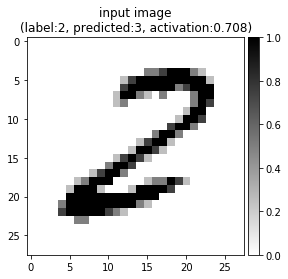

In [21]:
i = 492 # choose a test point

X = x_test[i]
title_str = 'input image\n(label:{}, predicted:{}, activation:{:.3})'
plt.title(title_str.format(labels_test[i], labels_pred[i], label_activations[i]))
nice_imshow(np.squeeze(X), vmin=0, vmax=1)

In [22]:
def make_mosaic(imgs, nrows, ncols, imshape, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[3]
    
    mosaic = np.ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        rmin, rmax = (row * paddedh, row * paddedh + imshape[0])
        cmin, cmax = (col * paddedw, col * paddedw + imshape[1])
        
        mosaic[rmin:rmax, cmin:cmax] = imgs[:,:,:,i].reshape(imshape[0],imshape[1])
    return mosaic


## Visualising the weights of the first convolutional layer

We can visualise the features the first convolutional layer has learned. First they must be retrieved from the trained model.

In [23]:
W, b = model.layers[0].get_weights()
print("W shape : ", W.shape)

W shape :  (3, 3, 1, 32)


The weights are the 32 kernels of size 3x3, which generate the feature representation when convolved across the input image.

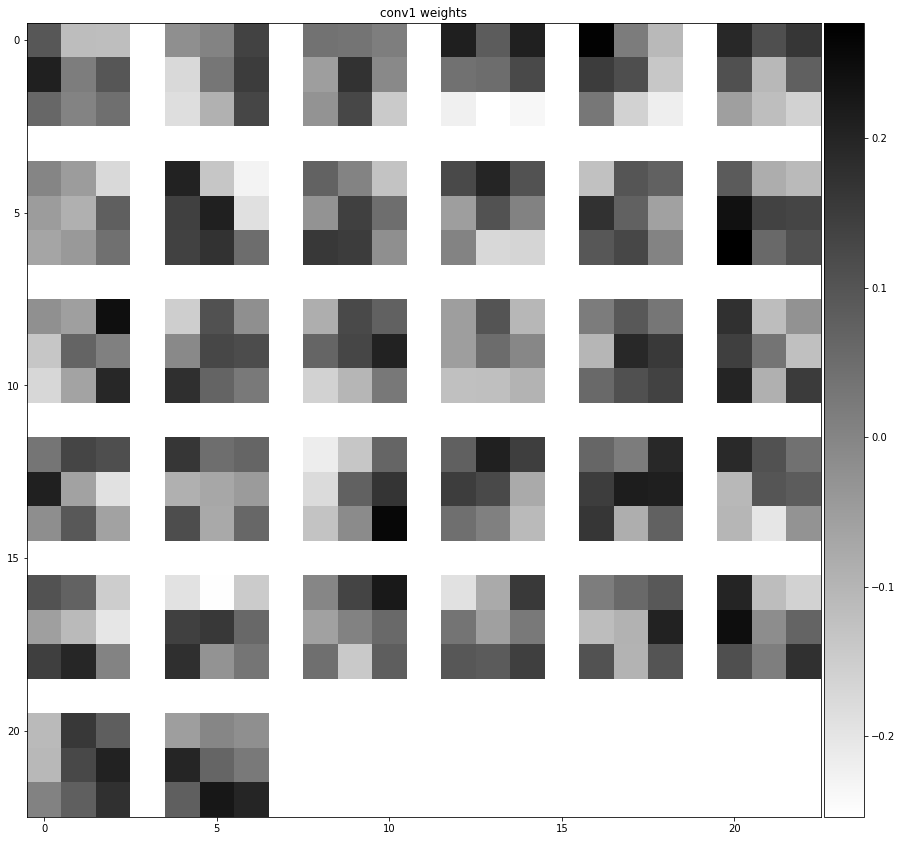

In [24]:
plt.figure(figsize=(15, 15))
plt.title('conv1 weights')
nice_imshow(make_mosaic(W, 6, 6, [3, 3]))

In [25]:
# K.learning_phase() is a flag that indicates if the network is in training or
# predict phase. It allow layer (e.g. Dropout) to only be applied during training
inputs = [K.learning_phase()] + model.inputs
_convout1_f = K.function(inputs, [convout1.output])
def convout1_f(X):
    # The [0] is to disable the training phase flag
    return _convout1_f([0] + [X])

We can also visualise the output of the layer when a given test point is fed through the network. These show the point in terms of the features the model has learned in order to allow the following layers to separate the classes. 

C1 shape :  (1, 26, 26, 32)


/Users/Dez/anaconda3/envs/malfoy/lib/python3.6/site-packages/matplotlib/image.py:414: RuntimeWarning: invalid value encountered in subtract
  A_scaled -= a_min
/Users/Dez/anaconda3/envs/malfoy/lib/python3.6/site-packages/matplotlib/colors.py:973: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)


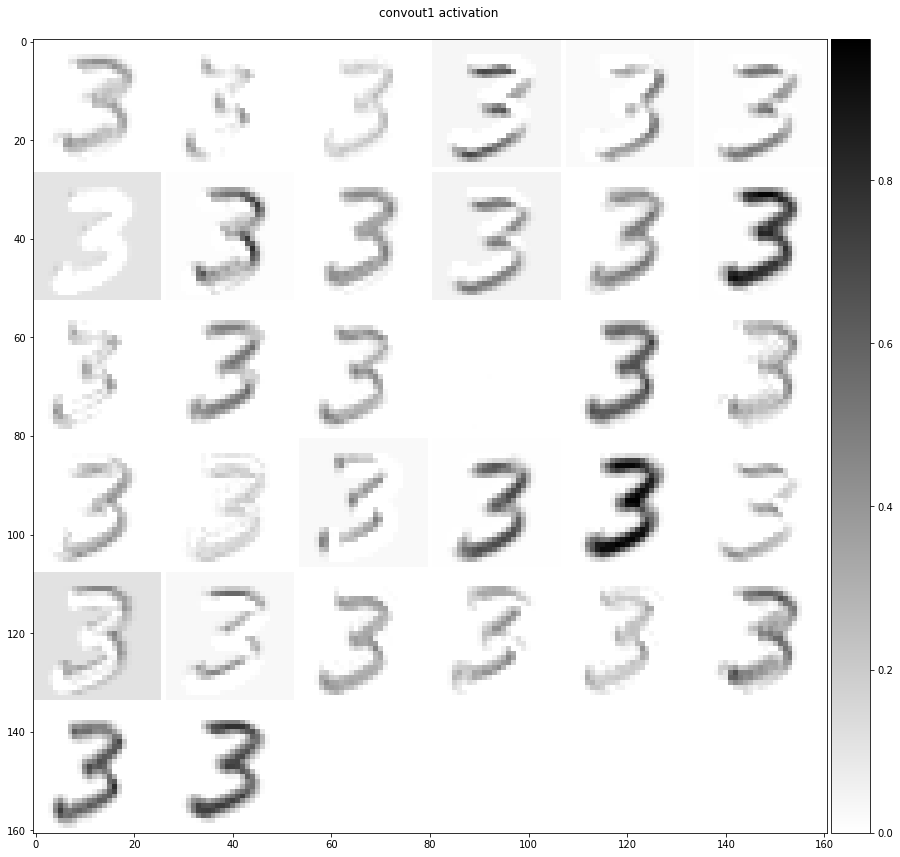

In [26]:
i = 4600 # choose a test point

# Visualize convolution result (after activation)
C1 = convout1_f(x_test[i:i+1])[0]
print("C1 shape : ", C1.shape)

plt.figure(figsize=(15, 15))
plt.suptitle('convout1 activation', position=(0.5, 0.9))
nice_imshow(make_mosaic(C1, 6, 6, [26, 26]))